In [17]:
import numpy as np
import pickle
import csv
import torch
from torch.linalg import inv, eig, pinv
from matplotlib import pyplot as plt
from tools import whiten, adap_whitening, adap_whitening_2
from sklearn import svm, metrics
from sklearn.decomposition import PCA
from datetime import datetime

In [18]:
def load(filename, reduced=True):
    sensor_data = []
    times = []
    responding_sens = [0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        # times = [row[0] for row in reader]
        for row in reader:
            if row[0] =='Timestamp':
                continue
            else:
                times.append(row[0])
                values = []
                for i in range(17):
                    b1 = int(row[2*i+1])
                    b2 = int(row[2*i+2])
                    values.append(int.from_bytes([b1, b2], byteorder="little"))
                sensor_data.append(values)
    sensor_data = np.array(sensor_data)
    if reduced:
        sensor_data = np.delete(sensor_data, np.where(np.array(responding_sens)==0)[0], axis=1)
    sequence = pickle.load(open('data/1_300_20_sequence.pkl', 'rb'))
    # Convert to seconds
    times_sec = []
    for dt_str in times:
        dt = datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S.%f')
        seconds = dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond / 1e6
        times_sec.append(seconds)
    sequence_sec = []
    for dt_str in sequence:
        dt = datetime.strptime(dt_str[0], '%a %b %d %H:%M:%S %Y')
        seconds = dt.hour * 3600 + dt.minute * 60 + dt.second
        sequence_sec.append(seconds)
    times_sec = np.array(times_sec)
    sequence_sec = np.array(sequence_sec)
    return sensor_data, sequence, times_sec, sequence_sec

In [19]:
def split(data, delay = 1.5, t_baseline = 300, n_train = 225):

    sensor_data = data[0]
    times_sec = data[1]
    sequence_sec = data[2]
    baseline = np.mean(sensor_data[:t_baseline], axis=0)    # Add baseline substraction
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []
    counts = np.zeros((3))

    for i, t in enumerate(sequence_sec):
        try:
            flags = (times_sec > sequence_sec[i]) & (times_sec < sequence_sec[i+1] + delay)
        except IndexError:
            flags = (times_sec > sequence_sec[i])
        sample = sensor_data[flags][:18]

        if counts[sequence[i][1]-1] < n_train//3:
            X_train.append(sample.flatten())
            Y_train.append(sequence[i][1]-1)
            counts[sequence[i][1]-1] += 1
        else:
            X_test.append(sample.flatten())
            Y_test.append(sequence[i][1]-1)

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    return X_train, Y_train, X_test, Y_test

In [ ]:
n_dense = 8
n_hd = 100000
n_out = 3
k = 500
n_pot = 2
lr = 1./n_pot
w_teacher = 1.
t_training_delay = 19.
filename = 'data/1_300_20.csv'


sensor_data, sequence, times_sec, sequence_sec = load(filename, reduced=True)
sensor_data_norm = (sensor_data - np.mean(sensor_data, axis=0))/ np.std(sensor_data, axis=0)
# x_dense, _, _, _ = adap_whitening_2(sensor_data_norm)
x_dense = whiten(sensor_data_norm)

labels = np.zeros_like(times_sec)
for i, t in enumerate(sequence_sec[:225]):
    try:
        flag = (times_sec > sequence_sec[i] + t_training_delay) & (times_sec < sequence_sec[i+1])
    except IndexError:
        flag = (times_sec > sequence_sec[i] + t_training_delay)
    labels[flag] = int(sequence[i][1])

idx_last_flag = np.where(labels != 0)[0][-1]
W_hd = np.random.uniform(high=1/np.sqrt(n_dense), size=(n_hd, n_dense))
x_hd = x_dense @ W_hd.T
z_hd = np.where(np.argsort(x_hd)<k, 1., 0)
W_out = np.zeros((n_out, n_hd))
W = np.zeros((n_out, n_hd))

z_out_train = np.zeros((z_hd.shape[0],  n_out))
for i, row in enumerate(z_hd[:idx_last_flag]):
    teacher = np.zeros((n_out,))
    if labels[i] != 0:
        teacher[int(labels[i]-1)] = w_teacher
    out = row @ W_out.T + teacher
    z_out_train[i] = out
    dW = lr*(np.atleast_2d(out).T @ np.atleast_2d(row))
    W += dW
    W_out = np.where(W>=1., 1./k, 0.)
    # if i%100 == 0:
    #     print(np.sum(W_out, axis=1))

z_out = np.zeros((z_hd.shape[0],  n_out))
for i, row in enumerate(z_hd):
    out = row @ W_out.T
    z_out[i] = out

z_wta = np.where(np.argsort(z_out, axis=1)<1, 1., 0)


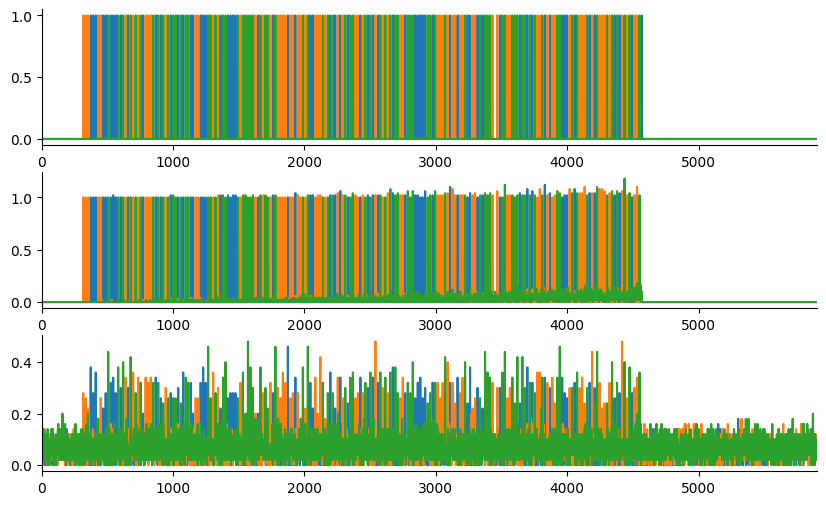

In [260]:
t0 = 000
t1 = 5900

fig, ax = plt.subplots(3, 1, figsize=(10, 6))

for i in range(3):
    ax[0].plot((labels==i+1)[t0:t1], label=f'Neuron {i+1}')
    ax[1].plot(z_out_train[t0:t1, i], label=f'Neuron {i+1}')
    ax[2].plot(z_out[t0:t1, i], label=f'Neuron {i+1}')
for a in fig.axes:
    a.spines[['top', 'right']].set_visible(False)
    a.set_xlim([0, t1-t0])
    # a.set_ylim([-0.05, 1.])
# plt.legend(frameon=False, loc='upper right')
plt.savefig('figs/hd_out.pdf', bbox_inches='tight')

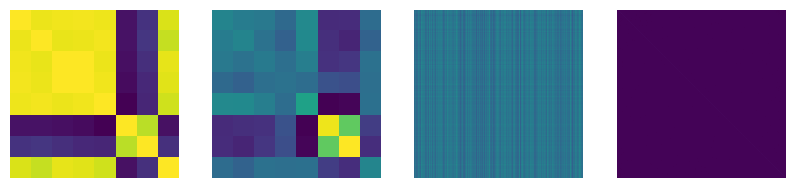

In [173]:
fig, ax = plt.subplots(1,4, figsize = (10,4))

ax[0].imshow(np.cov(sensor_data_norm.T))
ax[1].imshow(np.cov(x_dense.T))
ax[2].imshow(np.cov(x_hd.T))
ax[3].imshow(np.cov(z_hd.T))

for a in fig.axes:
    a.set_xticks([])
    a.set_yticks([])
    a.spines[:].set_visible(False)